<h3><span style="color:red">WORK IN PROGRESS</span></h3>

# Music Genre Classification
### 02452 - Audio Information Processing Systems

#### Bragi Marinosson (s185510) & Nicklas Hansen (s153077)

This notebook contains code and results for the exam project on Music Genre Classification for the 02452 graduate course offered at the Technical University of Denmark (DTU). Work has been equally distributed between the two authors and any questions can be directed at either of us.

The work presented in this notebook is to be considered open source under the MIT License. If you found this code useful in your research, then please cite


```
@inproceedings{mgc-marinosson-hansen,
  title={Music Genre Classification},
  author={Hansen, Nicklas and Marinosson, Bragi},
  year={2019}
}
```

#### Data

Raw, high-quality MP3-encoded audio data (30 s per sample) and genre classifications from the Free Music Archive (FMA) dataset is used in this study. For more information on the dataset, visit https://github.com/mdeff/fma/ and/or read the paper *FMA: A Dataset For Music Analysis*, Michaël Defferrard, Kirell Benzi, Pierre Vandergheynst, Xavier Bresson (2017).

As the original dataset contains 105 GB of audio data, we do not make that data available directly. To get your hands on the raw data, refer to the aforementioned website and paper. The original dataset is required in order to run the preprocessing steps in this code. Optionally, you can skip this step by setting the ``PREPROCESS`` global parameter to ``False`` and instead downloading our preprocessed data, which only takes up roughly 2 GB and saves you a lot of time. The preprocessed data is made available at the following link:

https://1drv.ms/u/s!AnqePMbr4kj8nvA7HBGWzBJIvOB-9w

Please note that we cannot guarantee the availability of this data indefinitely. Therefore, you may have to rerun the preprocessing step yourself in the future.

#### Setup

All code was developed and tested on Windows 10 (version 10.0.17134) with Python 3.7 and has been verified to work both with and without a GPU, although it is highly recommended to use one during training of neural networks as it decreases wall time significantly. For this study, a GTX1080 unit was used on a computer with 16 GB RAM.

#### Imports

Required dependencies are listed as imports below. If you intend to run this code on your own machine, please make sure that you have installed all of the below dependencies before proceeding.

In [1]:
import os
import sys
import numpy as np
import h5py
import pickle
import collections
from collections import defaultdict
from random import shuffle
import matplotlib.pyplot as plt
from sklearn import model_selection, neighbors, metrics
from sklearn.utils import shuffle
import time
from IPython.display import clear_output
import librosa
from librosa import display
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import Linear, RNN, LSTM
import torch.nn.functional as F
from torch.nn.functional import softmax, relu
from torch.autograd import Variable
import torch.optim as optim

C:\Users\nickl\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### Working directory as data path

You need to set this path to the root of the dataset, keeping all folders as is, but removing files in the root directory that are not MP3 files as the code does not check for this (resulting in less operations).

In [2]:
os.chdir('C:/FMA/')

#### Path to additional files

You need to set this path to a location that either contains files related to this code or a location in which you want to store such files.

In [3]:
GENRES = 'C:/Users/nickl/OneDrive/DTU_2019/Audio Information Processing Systems/Music Genre Classification/'

#### Set global seed for reproducibility

In [4]:
np.random.seed = int(0x02452)

#### Global parameters

``PREPROCESS`` determines whether the code should redo the preprocessing step or not. If you already preprocessed the original data or downloaded our preprocessed files, you can set ``PREPROCESS`` to ``False`` for a significant speed-up. Otherwise, you will have to complete the preprocessing step.

``NUM_CLASSES`` determines the number of genres to be used for classification. In this study we use 10 classes, but in principle this could be any number of classes (up to the number of genres in the dataset). Aside from the discarded classes as noted in the ``load_tracklist`` function, the classes used are selected based on the number of available samples (favoring a high count).

``NUM_FRAMES`` determines the number of frames used in each audio segment. Due to a window size of 2048 and a hop length of 1024, we require 128 frames to represent 3 seconds of audio as used in our study.

``MFCC_COEFFICIENTS`` determines the number of MFCC coefficients (frequency bands) to be used to model the Mel-frequency spectrum of the audio signal. A high number of coefficents produces a good frequency resolution but also requires proportionally more space and computation.

In [5]:
PREPROCESS = False

NUM_CLASSES = 10
NUM_FRAMES = 128
MFCC_COEFFICIENTS = 32

#### Get all available files

In [6]:
def load_data(target_file='train'):
    '''
    Loads any data from target location.
    '''
    with open(GENRES + target_file + '.pickle', 'rb') as handle:
        return pickle.load(handle)
    
    
def save_data(data, target_file='train'):
    '''
    Saves any data to target location.
    '''
    with open(GENRES + target_file + '.pickle', 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

def load_tracklist(discarded_genres=['Experimental', 'International', 'Instrumental', 'Old-Time / Historic', 'Spoken']):
    '''
    Load list of tracks with genre information as data frame.
    '''
    tracklist = pd.read_csv(GENRES + 'genres.csv').set_index('id', drop=True)
    
    tracklist = tracklist[tracklist.genre.notnull()]
    for genre in discarded_genres:
        tracklist = tracklist[tracklist.genre != genre]

    return tracklist


def get_file_list(verbose=False):
    '''
    Returns a list of all .h5 files in current working directory.
    '''
    files = []
    for r, d, f in os.walk(os.getcwd()):
        for file in f:
            if '.mp3' in file:
                files.append(os.path.join(r, file))

    print(f'Found {len(files)} files!')
    return files


def train_test_split(files, test_num=None, p=None):
    '''
    Returns two lists (train and test). If test_num is
    not None, the second list will contain test_num number
    of elements and the first list contains the remainder.
    If p is not None, lists are populated such that the first
    list contains elements selected with p probability
    and the second list contains elements selected with
    1-p probability (at random).
    '''
    if test_num is not None:
        return files[:-test_num], files[-test_num:]
    
    elif p is not None:
        lsts = [], []
        for file in files:
            a = np.random.choice(2, 1, p=[p, 1-p])[0]
            lsts[a].append(file)
        return lsts
    
    raise ParameterError('Either test_num or p must have a value!')

    
def id_from_filename(file):
    return str(int(file.split('\\')[-1].split('.')[0]))
    

def get_top_genres(genre_dict):
    '''
    Returns the top occurring genres as a list.
    '''
    lst = sorted(genre_dict, key=genre_dict.get, reverse=True)
    return lst[:NUM_CLASSES] if len(lst) > NUM_CLASSES else lst
    
    
def files_with_available_genre(files, predefined_tracklist=None, genre_cap=None, return_genre_count=False, verbose=False):
    
    lst, genres, tracklist = [], defaultdict(int), load_tracklist()

    for file in files:
        idx = id_from_filename(file)
        
        try:
            g = tracklist.loc[idx].genre
            
            if genre_cap is not None and genres[g] >= 1000:
                continue
                
            if (predefined_tracklist is None or g in predefined_tracklist):
                lst.append(file)
                genres[g] += 1
        except:
            continue
    
    if predefined_tracklist is None:
        print(f'Found {len(lst)} files with labels!')
    else:
        print(f'Found {len(lst)} files with labels among top {NUM_CLASSES} genres!')
    
    if return_genre_count is True:
        return lst, get_top_genres(genres), genres
    
    return lst, get_top_genres(genres)


if PREPROCESS is True:
    files, genres = files_with_available_genre(get_file_list(verbose=True), verbose=True)
    files, genres, genre_count = files_with_available_genre(shuffle(files), genres, genre_cap=1000, return_genre_count=True, verbose=True)
    
    train_files, test_files = train_test_split(files, p=0.9)
    class_weights = np.array([1/(genre_count[g]/(len(files)/NUM_CLASSES)) for g in genres])

    save_data((genres, class_weights), 'class_weights')
    
    print('\nTrain files:', len(train_files), '\nTest  files:', len(test_files), '\n\nClasses and class weights:')
    print(genres)
    print(class_weights)

#### Extract features

In [7]:
def mfcc_from_file(file, n_mfcc=MFCC_COEFFICIENTS):
    '''
    Computes MFCC coefficients of an audio file.
    '''
    x, sr = librosa.load(file, sr=None)
    return librosa.feature.mfcc(x, sr, n_mfcc=n_mfcc, n_fft=2048, hop_length=1024)


def generate_data(files, genres, target_file='train', skip_factor=1):
    '''
    Generates features and labels from from a sequence
    of filenames and stores the resulting data as a
    pickle object on the specified path.
    '''
    tracklist = load_tracklist()
    X, y = [], []
    
    for file_num, file in enumerate(files):
        try:
            mfccs = np.transpose(mfcc_from_file(file))
            idx, lbl = 0, tracklist.loc[id_from_filename(file)].genre
            while idx < mfccs.shape[0] - NUM_FRAMES:
                X.append(mfccs[idx:idx+NUM_FRAMES])
                y.append(genres.index(lbl))
                idx += NUM_FRAMES*skip_factor
        except:
            continue
            
        sys.stdout.write(f'\rGenerating {target_file} data: {int((file_num+1)*100/len(files))}% ({file_num+1})')
        sys.stdout.flush()
    
    save_data((X,y), target_file)
    print()
      
    
if PREPROCESS is True:
    generate_data(train_files, genres, target_file='train')
    generate_data(test_files, genres, target_file='test')

#### Load data from file

In [8]:
X_train, y_train = load_data('train')
X_train, y_train = shuffle(X_train, y_train)
print(f'Loaded {len(y_train)} sequences from train file.')

X_test, y_test = load_data('test')
print(f'Loaded {len(y_test)} sequences from test file.')

genres, class_weights = load_data('class_weights')
print(f'Loaded {len(genres)} classes and weights.')

Loaded 61829 sequences from train file.
Loaded 7152 sequences from test file.
Loaded 10 classes and weights.


#### Plot a single sample

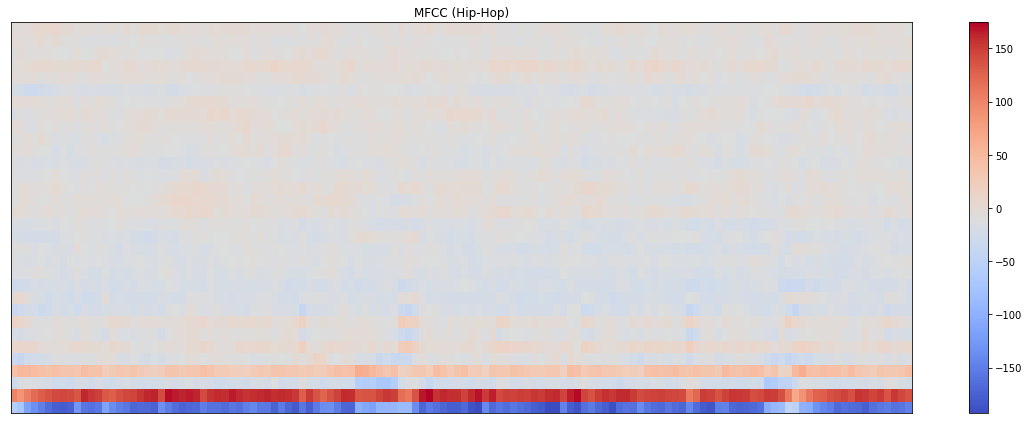

In [9]:
def plot_mfcc(x_mfcc, y):
    plt.figure(figsize=(16, 6))
    librosa.display.specshow(np.transpose(x_mfcc))
    plt.colorbar()
    plt.title(f'MFCC ({y})')
    plt.tight_layout()
    plt.show()
    
plot_mfcc(X_train[0], genres[y_train[0]])

## K-Nearest Neighbors

We will be using the traditional KNN classifier as a performance baseline. Because prediction time scales linearly with the number of dimensions, it is necessary to transform the features to a smaller dimensional space before feeding it into the classifier. We have chosen to use the sum of each frequency band across all timesteps as our transformation. This transformation completely discards the temporal information that we have available but that should be considered a limitation of the traditional KNN classifier.

#### Feature transform for KNN

In [10]:
X_knn_train = np.array([np.sum(x, axis=0) for x in X_train])
y_knn_train = y_train

X_knn_test = np.array([np.sum(x, axis=0) for x in X_test])
y_knn_test = y_test

#### KNN

In [11]:
knn = neighbors.KNeighborsClassifier(n_neighbors=3)
knn.fit(X_knn_train, y_knn_train)

y_pred = knn.predict(X_knn_test)
print('Accuracy:', str(int(metrics.accuracy_score(y_knn_test, y_pred)*100)) + '%\n')
print(metrics.classification_report(y_knn_test, y_pred))

for i in range(10):
    print(f'{i}: {genres[i]}')

Accuracy: 44%

             precision    recall  f1-score   support

          0       0.39      0.60      0.47      1045
          1       0.40      0.55      0.46       958
          2       0.43      0.38      0.40      1040
          3       0.38      0.33      0.35       964
          4       0.77      0.78      0.78      1203
          5       0.31      0.17      0.22       952
          6       0.26      0.19      0.22       570
          7       0.40      0.43      0.42       150
          8       0.34      0.20      0.25       170
          9       0.42      0.22      0.29       100

avg / total       0.44      0.45      0.43      7152

0: Rock
1: Hip-Hop
2: Folk
3: Electronic
4: Classical
5: Pop
6: Jazz
7: Country
8: Soul-RnB
9: Blues


## Neural Network

To improve classification performance, we choose to model the problem using a neural architecture. More specifically, we construct a deep convolutional neural network using 2D convolution, treating the MFCC features as an image.

#### Global parameters

In [12]:
WEIGHTED_LOSS = True # Weight loss based on class distribution

BATCH_SIZE = 256 # Hardware-dependent
CUDA = torch.cuda.is_available() # Check if we have a GPU available

print('CUDA has been enabled.' if CUDA else 'CUDA has been disabled.')

CUDA has been disabled.


#### Data partitioning

In [13]:
def convert_to_batches(data, is_y = False):
    '''
    Converts a list of numpy arrays to a list of
    batched numpy arrays of size BATCH_SIZE.
    '''
    batches, i = [], 0

    while i < len(data)-BATCH_SIZE:
        arr = data[i:i+BATCH_SIZE] if is_y is False else data[i:i+BATCH_SIZE]
        var = Variable(torch.from_numpy(np.array(arr)).float())
        if CUDA is True:
            var = var.cuda()
        batches.append(var)
        i += BATCH_SIZE
        
    return batches


X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train, y_train, test_size=0.1)

X_train, X_val, X_test = convert_to_batches(X_train), convert_to_batches(X_val), convert_to_batches(X_test)
y_train, y_val, y_test = convert_to_batches(y_train, is_y=True), convert_to_batches(y_val, is_y=True), convert_to_batches(y_test, is_y=True)

print(f'Generated ({len(y_train)}, {len(y_val)}, {len(y_test)}) batches for training, validation and test.')

Generated (217, 24, 27) batches for training, validation and test.


#### Baseline network

In [14]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
    
        self.a = nn.ReLU()    
        self.hidden = self.init_hidden()
        
        self.rnn = LSTM(input_size=MFCC_COEFFICIENTS, hidden_size=NUM_FRAMES, num_layers=1, batch_first=True)        
        self.lin = nn.Linear(NUM_FRAMES**2, int(NUM_FRAMES**1.5))
        self.out = nn.Linear(int(NUM_FRAMES**1.5), NUM_CLASSES)
        self.softmax = nn.Softmax(dim=1)
    
    
    def init_hidden(self):
        h = Variable(torch.zeros(1, BATCH_SIZE, NUM_FRAMES))
        c = Variable(torch.zeros(1, BATCH_SIZE, NUM_FRAMES))
        
        if CUDA:
            h = h.cuda()
            c = c.cuda()
        
        return h, c
    
    
    def forward(self, x):
        # (batch, frames, features)
        x, _ = self.rnn(x, self.hidden)
        x = x.contiguous().view(-1, NUM_FRAMES**2)
        
        # (batch, units)
        x = self.a(self.lin(x))
        return self.softmax(self.out(x))
    

net = Net()
print(net, '\n')

try:
    out = net(X_train[0])
    print('Successfully passed data through network.')
except Exception as e:
    print('An error occurred while passing data through network:\n' + str(e))

Net(
  (a): ReLU()
  (rnn): LSTM(32, 128, batch_first=True)
  (lin): Linear(in_features=16384, out_features=1448, bias=True)
  (out): Linear(in_features=1448, out_features=10, bias=True)
  (softmax): Softmax()
) 

Successfully passed data through network.


#### Training

In [15]:
def accuracy(out, y):
    '''
    Calculate accuracy of model where
    out.shape = (batches, classes) and y.shape = (batches)
    '''
    out = torch.max(out, 1)[1].float()
    eq = torch.eq(out, y.float()).float()
    return torch.mean(eq)


def train_net(net, epochs=10, lr=1e-3, verbose=True):

    # Move network to GPU if available
    if CUDA:
        net.cuda()
        
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=lr/100)
    losses, accs, val_losses, val_accs = [], [], [], []
    
    if verbose:
        start_time = time.time()
    
    def plot(losses, accs, val_losses, val_accs):
        '''
        Continously plots the training/validation loss and accuracy
        of the model being trained. This functions is only called if
        verbose is True for the training session.
        '''
        e = [i for i in range(len(losses))]
        fig = plt.figure(figsize=(12,4))
        plt.subplot(1, 2, 1)
        plt.plot(e, losses, label='Loss (Training)')
        
        plt.plot(e, val_losses, label='Loss (Validation)')
            
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(e, accs, label='Accuracy (Training)')
        
        plt.plot(e, val_accs, label='Accuracy (Validation)')
            
        plt.legend()
        plt.show()
        clear_output(wait=True)
    
    def run(net, X, y, optimize = False):
        '''
        This function constitutes a single epoch.
        If optimize is True, the associated optimizer will backpropagate
        and adjust network weights.
        Returns the average sample loss and accuracy for that epoch.
        '''
        epoch_loss, epoch_acc = 0, []
        
        if len(X) == 0 or len(y) == 0:
            raise ValueError('Something went wrong. Invalid input!')
        
        # Helper function responsible for running a batch
        def run_batch(X, y, epoch_loss, epoch_acc):

            y = y.long()

            if CUDA:
                X = X.cuda()
                y = y.cuda()

            out = net(X)

            # Compute loss and accuracy for batch
            batch_loss = criterion(out, y)
            batch_acc = accuracy(out, y)

            # If training session, initiate backpropagation and optimization
            if optimize == True:
                optimizer.zero_grad()
                batch_loss.backward()
                optimizer.step()

            if CUDA:
                batch_acc = batch_acc.cpu()
                batch_loss = batch_loss.cpu()

            # Accumulate loss and accuracy for epoch metrics
            epoch_loss += batch_loss.data.numpy() / float(BATCH_SIZE)
            epoch_acc.append(batch_acc.data.numpy())

            return epoch_loss, epoch_acc

        # For each batch
        for i,x in enumerate(X):
            temp_loss, temp_acc = run_batch(x, y[i], epoch_loss, epoch_acc)
            epoch_loss += temp_loss / float(len(X))
            epoch_acc.append(np.mean(temp_acc))

        return epoch_loss, np.mean(epoch_acc)
    
    
    # Iterate over training epochs
    for epoch in range(epochs):
        
        net.train()
        loss, acc = run(net, X_train, y_train, optimize=True)
        losses.append(loss)
        accs.append(acc)
        
        net.eval()
        val_loss, val_acc = run(net, X_test, y_test)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Optionally plot performance metrics continously
        if verbose:
            
            # Print measured wall-time of first epoch
            if epoch == 0:
                dur = str(int((time.time() - start_time)/60))
                print(f'\nEpoch wall-time: {dur} min')
                
            plot(losses, accs, val_losses, val_accs)
    
train_net(net)

KeyboardInterrupt: 